created 10/26

We would like to create bathymetry so that we can run an idealized model to study AMOC in the tropics. Since we want to investigate a specific location, we use an idealized model because MOM6 is a global model, not a regional model. We want to release particles in the idealized model to follow water parcels and its vertical and horizontal motion through the tropics. 

# <font color ="hotpink"> Exact Recreation of [Neverworld2 Github Notebook](https://github.com/ocean-eddy-cpt/NeverWorld2/blob/main/docs/NeverWorld2.ipynb) described in [this paper](https://gmd.copernicus.org/articles/15/6567/2022/) </font>

In [1]:
pip install cartopy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install xarray

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install netCDF4

Note: you may need to restart the kernel to use updated packages.


In [6]:
import cartopy
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import scipy.interpolate
import xarray as xr
import netCDF4 as nc4
import topo_builder # module retrieved from topo_builder.py from neverworld2 code imported to /home/jupyter-kuyeda

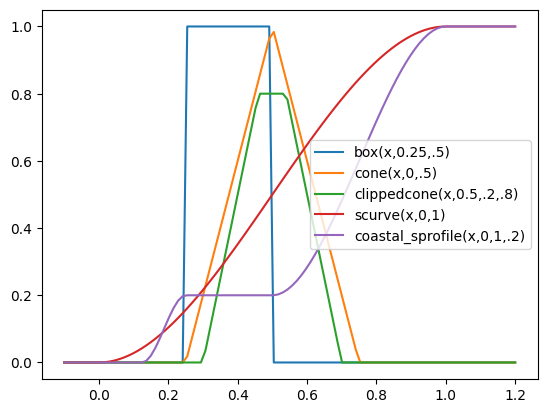

In [7]:
# These are some basic building blocks
ax = plt.subplot(111)
topo_builder.topo.test1d(ax)

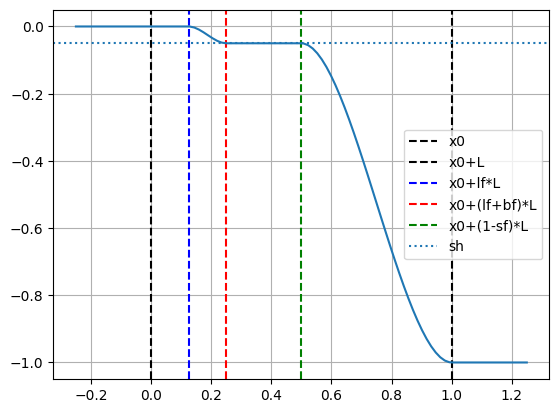

In [8]:
# Profile used at coasts
x = np.linspace(-.25,1.25,100)
x0 = 0; plt.axvline(x0, linestyle='--', color='k', label='x0')
L = 1; plt.axvline(x0+L, linestyle='--', color='k', label='x0+L')
lf = 0.125; plt.axvline(x0+lf*L, linestyle='--', color='b', label='x0+lf*L')
bf = 0.125; plt.axvline(x0+(lf+bf)*L, linestyle='--', color='r', label='x0+(lf+bf)*L')
sf = 0.5; plt.axvline(x0+(1-sf)*L, linestyle='--', color='g', label='x0+(1-sf)*L')
sh = 0.05; plt.axhline(-sh, linestyle=':', label='sh')
plt.plot(x, -topo_builder.topo.coastal_sprofile(x, x0, L, sh, lf, bf, sf) )
plt.grid()
plt.legend();

In [9]:
# NeverWorld2 domain
NW2_lonW, NW2_lonE = 0, 80
NW2_latS, NW2_latN = -70, 70

D0 = 4000 # Nominal depth (m)
cd = 200 # Depth of coastal shelf (m)
drake = 2500 # Depth of Drake sill (m)
cw = 5 # Width of coastal shelf (degrees)

# Logical domain (grid points)
nj, ni = 140, 80

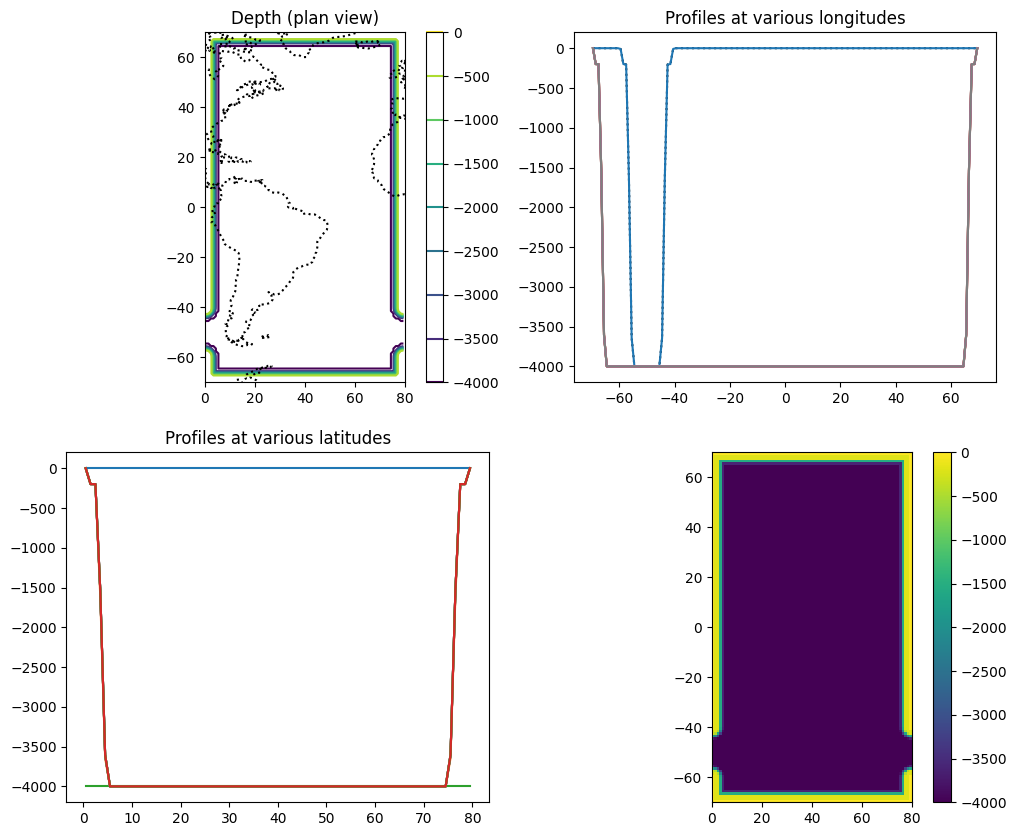

In [10]:
# Simple "Atlantic" box with re-entrant Drake passage

T = topo_builder.topo(nj, ni, dlon=NW2_lonE, dlat=NW2_latN-NW2_latS, lat0=NW2_latS, D=D0)
T.add_NS_coast(NW2_lonW, -40, 90, cw, cd)
T.add_NS_coast(NW2_lonE, -40, 90, cw, cd)
T.add_NS_coast(NW2_lonW, -90, -60, cw, cd)
T.add_NS_coast(NW2_lonE, -90, -60, cw, cd)
T.add_EW_coast(-360, 360, NW2_latS, cw, cd)
T.add_EW_coast(-360, 360, NW2_latN, cw, cd)

fig = plt.figure(figsize=(12,10))
T.plot(fig, Atlantic_lon_offset=-84)

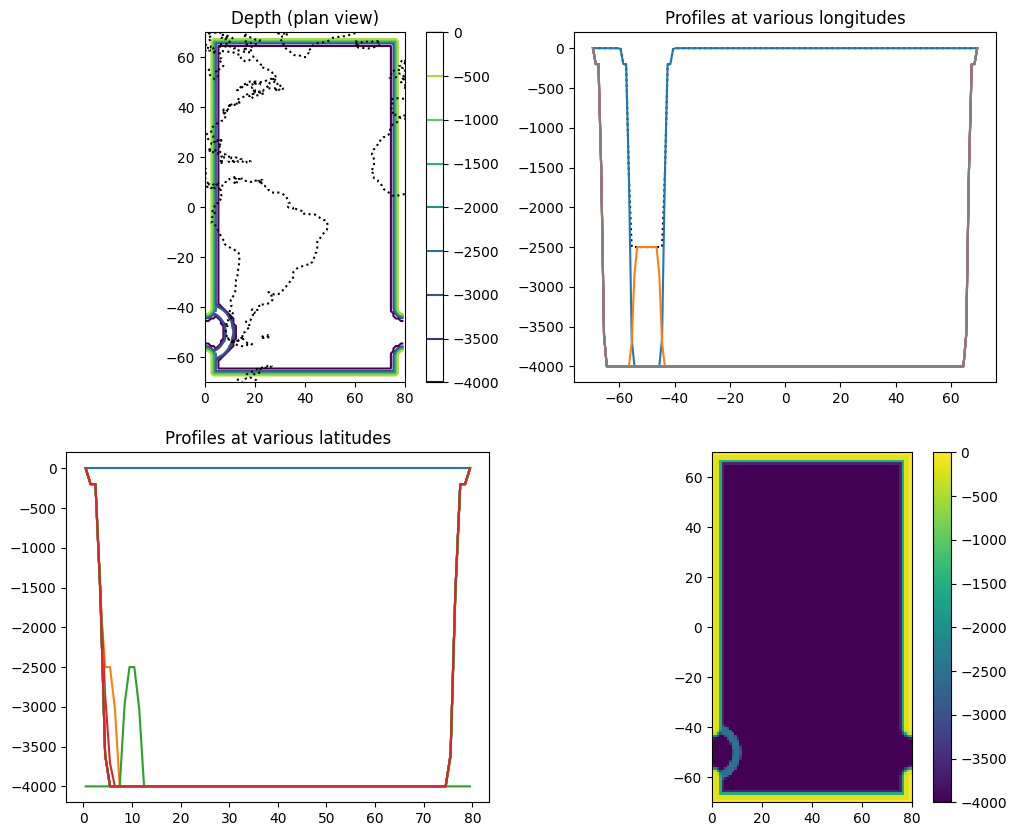

In [11]:
# Add a sill to Drake passage
T.add_circular_ridge(NW2_lonW, -50, 10, 2, drake) # Drake sill

fig = plt.figure(figsize=(12,10))
T.plot(fig, Atlantic_lon_offset=-84)

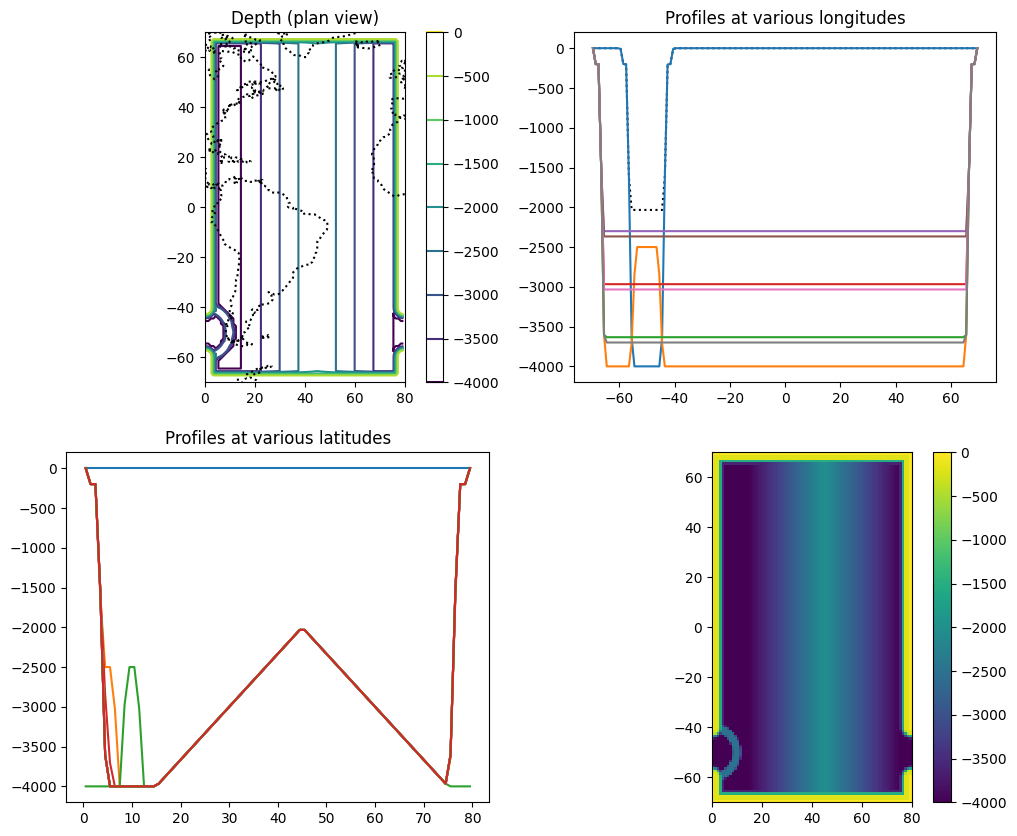

In [12]:
# Add a "Mid-Atlantic" ridge
T.add_NS_ridge(45, -90, 90, 30, D0/2) # Mid-Atlantic ridge?

fig = plt.figure(figsize=(12,10))
T.plot(fig, Atlantic_lon_offset=-84)

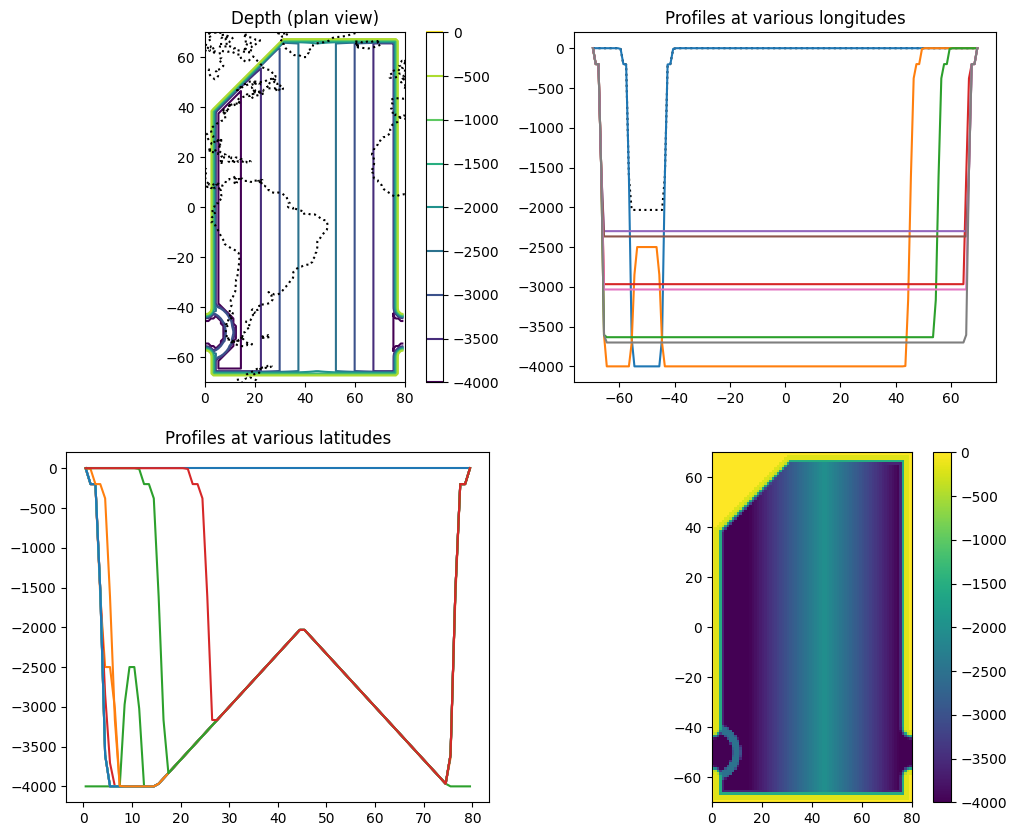

In [13]:
# Add a "New England" coastline
T.add_angled_coast(-40, 40, cw, cd) # New England

fig = plt.figure(figsize=(12,10))
T.plot(fig, Atlantic_lon_offset=-84)

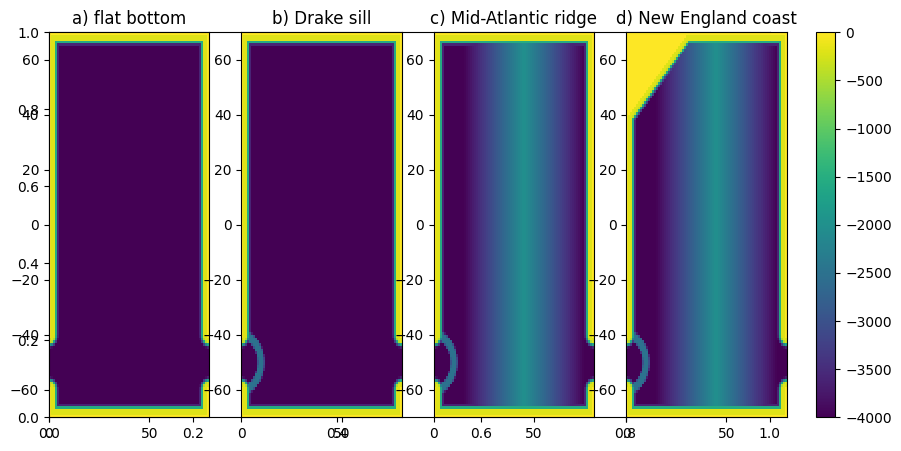

In [14]:
# Side-b-side comparison for discussion purposes
fig,axs = plt.subplots(1,1,figsize=(12,5))

T = topo_builder.topo(nj, ni, dlon=NW2_lonE, dlat=NW2_latN-NW2_latS, lat0=NW2_latS, D=D0)
T.add_NS_coast(NW2_lonW, -40, 90, cw, cd)
T.add_NS_coast(NW2_lonE, -40, 90, cw, cd)
T.add_NS_coast(NW2_lonW, -90, -60, cw, cd)
T.add_NS_coast(NW2_lonE, -90, -60, cw, cd)
T.add_EW_coast(-360, 360, NW2_latS, cw, cd)
T.add_EW_coast(-360, 360, NW2_latN, cw, cd)

plt.subplot(151)
plt.pcolormesh(T.xg, T.yg, T.z); plt.title('a) flat bottom')

T.add_circular_ridge(NW2_lonW, -50, 10, 2, drake) # Drake sill
plt.subplot(152)
plt.pcolormesh(T.xg, T.yg, T.z); plt.title('b) Drake sill')

T.add_NS_ridge(45, -90, 90, 30, D0/2) # Mid-Atlantic ridge?
plt.subplot(153)
plt.pcolormesh(T.xg, T.yg, T.z); plt.title('c) Mid-Atlantic ridge')

T.add_angled_coast(-40, 40, cw, cd) # New England
plt.subplot(154)
im = plt.pcolormesh(T.xg, T.yg, T.z); plt.title('d) New England coast')

cb = fig.colorbar(im, ax=axs, orientation='vertical', fraction=.175)

# <font color ="hotpink"> Using the configurations demonstrated above I will create my own netcdf topography file for use in MOM6. It will utilize the NS_ridge command. </font>

In [15]:
# NeverWorld2 domain
NW2_lonW, NW2_lonE = 0, 80
NW2_latS, NW2_latN = -70, 70

D0 = 4000 # Nominal depth (m)
cd = 200 # Depth of coastal shelf (m)
drake = 2500 # Depth of Drake sill (m)
cw = 5 # Width of coastal shelf (degrees)

# Logical domain (grid points)
nj, ni = 140, 80

In [16]:
for_ridge = topo_builder.topo(nj, ni, dlon=NW2_lonE, dlat=NW2_latN-NW2_latS, lat0=NW2_latS, D=D0)
for_ridge.add_NS_coast(NW2_lonW, -40, 90, cw, cd)
for_ridge.add_NS_coast(NW2_lonE, -40, 90, cw, cd)
for_ridge.add_NS_coast(NW2_lonW, -90, -60, cw, cd)
for_ridge.add_NS_coast(NW2_lonE, -90, -60, cw, cd)
for_ridge.add_EW_coast(-360, 360, NW2_latS, cw, cd)
for_ridge.add_EW_coast(-360, 360, NW2_latN, cw, cd)
for_ridge.add_NS_ridge(40, -70, 140, 30, D0/2) # Mid-Atlantic ridge?

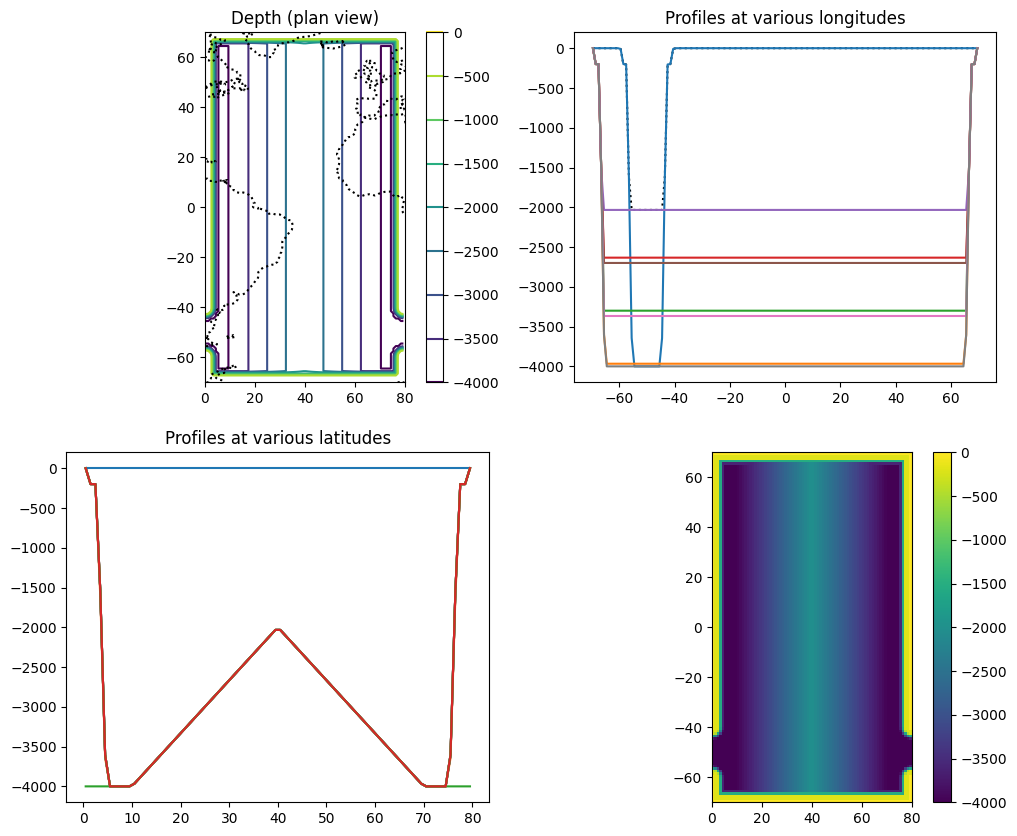

In [17]:
fig = plt.figure(figsize=(12,10))
for_ridge.plot(fig, Atlantic_lon_offset=-70)

In [18]:
ds = xr.Dataset()
xh = for_ridge.xc
yh = for_ridge.yc
xq = for_ridge.xg
yq = for_ridge.yg

In [19]:
pwd

'/vortex1/jupyter-kuyeda/t_m_p_wind/6-21_build_INPUT'

In [23]:
import netCDF4 as nc4
f = nc4.Dataset('/vortex1/jupyter-kuyeda/files_to_delete/topo_file_test3.nc','w',format='NETCDF4')

In [24]:
try: ncfile.close()
except:pass
print(f)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 


## create dimensions

In [25]:
xh_dim = f.createDimension('xh',len(xh))
yh_dim = f.createDimension('yh',len(yh))
xq_dim = f.createDimension('xq',len(xq))
yq_dim = f.createDimension('yq',len(yq))
for dim in f.dimensions.items():
    print(dim)

('xh', <class 'netCDF4._netCDF4.Dimension'>: name = 'xh', size = 80)
('yh', <class 'netCDF4._netCDF4.Dimension'>: name = 'yh', size = 140)
('xq', <class 'netCDF4._netCDF4.Dimension'>: name = 'xq', size = 81)
('yq', <class 'netCDF4._netCDF4.Dimension'>: name = 'yq', size = 141)


## create attributes

In [26]:
f.title='Neverworld2 test bathymetry'
print(f.title)

Neverworld2 test bathymetry


In [27]:
f.subtitle='subtitle'
print(f.subtitle)
print(f)

subtitle
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Neverworld2 test bathymetry
    subtitle: subtitle
    dimensions(sizes): xh(80), yh(140), xq(81), yq(141)
    variables(dimensions): 
    groups: 


## create variables

In [28]:
# coordinate variables
xh = f.createVariable('xh',np.float32,('xh'))
xh.units = 'degrees_east'
xh.long_name = 'longitude'

In [29]:
yh = f.createVariable('yh',np.float32,('yh'))
yh.units = 'degrees_north'
yh.long_name = 'latitude'

In [30]:
xq = f.createVariable('xq',np.float32,('xq'))
xq.units = 'degrees_east'
xq.long_name = 'longitude'

In [31]:
yq = f.createVariable('yq',np.float32,('yq'))
yq.units = 'degrees_north'
yq.long_name = 'latitude'

In [32]:
z = f.createVariable('z',np.float32,('yh','xh'))
z.long_name = 'field_depth'
z.units = 'm'
print(z)

<class 'netCDF4._netCDF4.Variable'>
float32 z(yh, xh)
    long_name: field_depth
    units: m
unlimited dimensions: 
current shape = (140, 80)
filling on, default _FillValue of 9.969209968386869e+36 used


In [33]:
z[:,:]=-for_ridge.z

In [34]:
print("-- Min/Max values:",z[:,:].min(),z[:,:].max())

-- Min/Max values: 0.0 4000.0


In [35]:
xh[:]= for_ridge.xc
print(xh[:])
print(xh.units)

[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
 14.5 15.5 16.5 17.5 18.5 19.5 20.5 21.5 22.5 23.5 24.5 25.5 26.5 27.5
 28.5 29.5 30.5 31.5 32.5 33.5 34.5 35.5 36.5 37.5 38.5 39.5 40.5 41.5
 42.5 43.5 44.5 45.5 46.5 47.5 48.5 49.5 50.5 51.5 52.5 53.5 54.5 55.5
 56.5 57.5 58.5 59.5 60.5 61.5 62.5 63.5 64.5 65.5 66.5 67.5 68.5 69.5
 70.5 71.5 72.5 73.5 74.5 75.5 76.5 77.5 78.5 79.5]
degrees_east


In [36]:
yh[:]= for_ridge.yc
print(yh[:])
print(yh.units)

[-69.5 -68.5 -67.5 -66.5 -65.5 -64.5 -63.5 -62.5 -61.5 -60.5 -59.5 -58.5
 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 -51.5 -50.5 -49.5 -48.5 -47.5 -46.5
 -45.5 -44.5 -43.5 -42.5 -41.5 -40.5 -39.5 -38.5 -37.5 -36.5 -35.5 -34.5
 -33.5 -32.5 -31.5 -30.5 -29.5 -28.5 -27.5 -26.5 -25.5 -24.5 -23.5 -22.5
 -21.5 -20.5 -19.5 -18.5 -17.5 -16.5 -15.5 -14.5 -13.5 -12.5 -11.5 -10.5
  -9.5  -8.5  -7.5  -6.5  -5.5  -4.5  -3.5  -2.5  -1.5  -0.5   0.5   1.5
   2.5   3.5   4.5   5.5   6.5   7.5   8.5   9.5  10.5  11.5  12.5  13.5
  14.5  15.5  16.5  17.5  18.5  19.5  20.5  21.5  22.5  23.5  24.5  25.5
  26.5  27.5  28.5  29.5  30.5  31.5  32.5  33.5  34.5  35.5  36.5  37.5
  38.5  39.5  40.5  41.5  42.5  43.5  44.5  45.5  46.5  47.5  48.5  49.5
  50.5  51.5  52.5  53.5  54.5  55.5  56.5  57.5  58.5  59.5  60.5  61.5
  62.5  63.5  64.5  65.5  66.5  67.5  68.5  69.5]
degrees_north


In [37]:
xq[:]= for_ridge.xg
print([xq[:]])
print(xq.units)

[masked_array(data=[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.,
                   11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21.,
                   22., 23., 24., 25., 26., 27., 28., 29., 30., 31., 32.,
                   33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43.,
                   44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54.,
                   55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65.,
                   66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76.,
                   77., 78., 79., 80.],
             mask=False,
       fill_value=1e+20,
            dtype=float32)]
degrees_east


In [38]:
yq[:]= for_ridge.yg
print(yq[:])
print(yq.units)

[-70. -69. -68. -67. -66. -65. -64. -63. -62. -61. -60. -59. -58. -57.
 -56. -55. -54. -53. -52. -51. -50. -49. -48. -47. -46. -45. -44. -43.
 -42. -41. -40. -39. -38. -37. -36. -35. -34. -33. -32. -31. -30. -29.
 -28. -27. -26. -25. -24. -23. -22. -21. -20. -19. -18. -17. -16. -15.
 -14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.
   0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.]
degrees_north


In [39]:
print(f)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Neverworld2 test bathymetry
    subtitle: subtitle
    dimensions(sizes): xh(80), yh(140), xq(81), yq(141)
    variables(dimensions): float32 xh(xh), float32 yh(yh), float32 xq(xq), float32 yq(yq), float32 z(yh, xh)
    groups: 


In [40]:
f.close(); print('dataset is closed')

dataset is closed


In [41]:
sample=xr.open_dataset('/vortex1/jupyter-kuyeda/t_m_p_wind/6-21_build_INPUT/6-21_INPUT_files/topo_file_test1.nc')
sample

<xarray.Dataset>
Dimensions:  (xh: 80, yh: 140, xq: 81, yq: 141)
Coordinates:
  * xh       (xh) float32 0.5 1.5 2.5 3.5 4.5 5.5 ... 75.5 76.5 77.5 78.5 79.5
  * yh       (yh) float32 -69.5 -68.5 -67.5 -66.5 -65.5 ... 66.5 67.5 68.5 69.5
  * xq       (xq) float32 0.0 1.0 2.0 3.0 4.0 5.0 ... 76.0 77.0 78.0 79.0 80.0
  * yq       (yq) float32 -70.0 -69.0 -68.0 -67.0 -66.0 ... 67.0 68.0 69.0 70.0
Data variables:
    z        (yh, xh) float32 ...
Attributes:
    title:     Neverworld2 test bathymetry
    subtitle:  subtitle

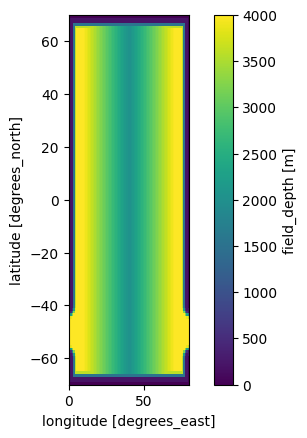

In [42]:
fig,ax = plt.subplots(nrows=1,ncols=1)
sample.z.plot()
ax.set_aspect(140/80)

# <font color="hotpink"> Now, we need to create a wind forcing file. I'm doing it in the same nb as where we created the topography file because xh, yh, xq, yq are already defined. 

In [43]:
import netCDF4 as nc4
f1 = nc4.Dataset('/vortex1/jupyter-kuyeda/files_to_delete/wind_sample_nov_10.nc','w',format='NETCDF4')

In [44]:
try: ncfile.close()
except:pass
print(f1)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 


## <font color="hotpink"> create dimensions</font>

In [45]:
np.delete(for_ridge.yg,obj=0,axis=0)

array([-69., -68., -67., -66., -65., -64., -63., -62., -61., -60., -59.,
       -58., -57., -56., -55., -54., -53., -52., -51., -50., -49., -48.,
       -47., -46., -45., -44., -43., -42., -41., -40., -39., -38., -37.,
       -36., -35., -34., -33., -32., -31., -30., -29., -28., -27., -26.,
       -25., -24., -23., -22., -21., -20., -19., -18., -17., -16., -15.,
       -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,
        -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,
         8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,
        19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,
        30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,
        41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,
        52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,
        63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.])

## we delete part the first row from `for_ridge.yg` and the first column from `for_ridge.xg` because they are located at corners of the grid cell (not the middle), and since we want temp to sit on the (yh,xh) coordinates, they should be deleted since (yg,xg) would extend beyond the grid

In [46]:
xh = for_ridge.xc
yh = for_ridge.yc
xq = np.delete(for_ridge.xg,obj=0,axis=0)
yq = np.delete(for_ridge.yg,obj=0,axis=0)

In [47]:
xh_dim = f1.createDimension('xh',len(xh))
yh_dim = f1.createDimension('yh',len(yh))
xq_dim = f1.createDimension('xq',len(xq))
yq_dim = f1.createDimension('yq',len(yq))
for dim in f1.dimensions.items():
    print(dim)

('xh', <class 'netCDF4._netCDF4.Dimension'>: name = 'xh', size = 80)
('yh', <class 'netCDF4._netCDF4.Dimension'>: name = 'yh', size = 140)
('xq', <class 'netCDF4._netCDF4.Dimension'>: name = 'xq', size = 80)
('yq', <class 'netCDF4._netCDF4.Dimension'>: name = 'yq', size = 140)


## <font color="hotpink"> create attributes </font>

In [48]:
f1.title='wind forcing test'
print(f1.title)

wind forcing test


In [49]:
f1.subtitle='subtitle'
print(f1.subtitle)
print(f1)

subtitle
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: wind forcing test
    subtitle: subtitle
    dimensions(sizes): xh(80), yh(140), xq(80), yq(140)
    variables(dimensions): 
    groups: 


## <font color="hotpink"> create variables </font>

In [50]:
# coordinate variables
xh = f1.createVariable('xh',np.float32,('xh'))
xh.units = 'degrees_east'
xh.long_name = 'longitude'

In [51]:
yh = f1.createVariable('yh',np.float32,('yh'))
yh.units = 'degrees_north'
yh.long_name = 'latitude'

In [52]:
xq = f1.createVariable('xq',np.float32,('xq'))
xq.units = 'degrees_east'
xq.long_name = 'longitude'

In [53]:
yq = f1.createVariable('yq',np.float32,('yq'))
yq.units = 'degrees_north'
yq.long_name = 'latitude'

In [54]:
taux = f1.createVariable('taux',np.float32,('yh','xq'))
taux.long_name = 'zonal surface wind forcing'
taux.units = 'Pa'
print(taux)

<class 'netCDF4._netCDF4.Variable'>
float32 taux(yh, xq)
    long_name: zonal surface wind forcing
    units: Pa
unlimited dimensions: 
current shape = (140, 80)
filling on, default _FillValue of 9.969209968386869e+36 used


In [55]:
tauy = f1.createVariable('tauy',np.float32,('yq','xh'))
tauy.long_name = 'meridional surface wind forcing'
tauy.units = 'Pa'
print(tauy)

<class 'netCDF4._netCDF4.Variable'>
float32 tauy(yq, xh)
    long_name: meridional surface wind forcing
    units: Pa
unlimited dimensions: 
current shape = (140, 80)
filling on, default _FillValue of 9.969209968386869e+36 used


## <font color="hotpink"> assign variables </font>

In [56]:
xh[:]= for_ridge.xc
print(xh[:])
print(xh.units)

[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
 14.5 15.5 16.5 17.5 18.5 19.5 20.5 21.5 22.5 23.5 24.5 25.5 26.5 27.5
 28.5 29.5 30.5 31.5 32.5 33.5 34.5 35.5 36.5 37.5 38.5 39.5 40.5 41.5
 42.5 43.5 44.5 45.5 46.5 47.5 48.5 49.5 50.5 51.5 52.5 53.5 54.5 55.5
 56.5 57.5 58.5 59.5 60.5 61.5 62.5 63.5 64.5 65.5 66.5 67.5 68.5 69.5
 70.5 71.5 72.5 73.5 74.5 75.5 76.5 77.5 78.5 79.5]
degrees_east


In [57]:
yh[:]= for_ridge.yc
print(yh[:])
print(yh.units)

[-69.5 -68.5 -67.5 -66.5 -65.5 -64.5 -63.5 -62.5 -61.5 -60.5 -59.5 -58.5
 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 -51.5 -50.5 -49.5 -48.5 -47.5 -46.5
 -45.5 -44.5 -43.5 -42.5 -41.5 -40.5 -39.5 -38.5 -37.5 -36.5 -35.5 -34.5
 -33.5 -32.5 -31.5 -30.5 -29.5 -28.5 -27.5 -26.5 -25.5 -24.5 -23.5 -22.5
 -21.5 -20.5 -19.5 -18.5 -17.5 -16.5 -15.5 -14.5 -13.5 -12.5 -11.5 -10.5
  -9.5  -8.5  -7.5  -6.5  -5.5  -4.5  -3.5  -2.5  -1.5  -0.5   0.5   1.5
   2.5   3.5   4.5   5.5   6.5   7.5   8.5   9.5  10.5  11.5  12.5  13.5
  14.5  15.5  16.5  17.5  18.5  19.5  20.5  21.5  22.5  23.5  24.5  25.5
  26.5  27.5  28.5  29.5  30.5  31.5  32.5  33.5  34.5  35.5  36.5  37.5
  38.5  39.5  40.5  41.5  42.5  43.5  44.5  45.5  46.5  47.5  48.5  49.5
  50.5  51.5  52.5  53.5  54.5  55.5  56.5  57.5  58.5  59.5  60.5  61.5
  62.5  63.5  64.5  65.5  66.5  67.5  68.5  69.5]
degrees_north


In [58]:
xq[:]= np.delete(for_ridge.xg,obj=0,axis=0)
print([xq[:]])
print(xq.shape)

[masked_array(data=[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
                   12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22.,
                   23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33.,
                   34., 35., 36., 37., 38., 39., 40., 41., 42., 43., 44.,
                   45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
                   56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66.,
                   67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
                   78., 79., 80.],
             mask=False,
       fill_value=1e+20,
            dtype=float32)]
(80,)


In [59]:
yq[:]= np.delete(for_ridge.yg,obj=0,axis=0)
print(yq[:])
print(yq.units)
print(yq.shape)

[-69. -68. -67. -66. -65. -64. -63. -62. -61. -60. -59. -58. -57. -56.
 -55. -54. -53. -52. -51. -50. -49. -48. -47. -46. -45. -44. -43. -42.
 -41. -40. -39. -38. -37. -36. -35. -34. -33. -32. -31. -30. -29. -28.
 -27. -26. -25. -24. -23. -22. -21. -20. -19. -18. -17. -16. -15. -14.
 -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.
   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.]
degrees_north
(140,)


## <font color="hotpink"> create an array of valeus for taux and tauy. </font>

$$ 
\tau = \tau_{max} \left[ - cos\left(\frac{3 \pi \theta}{140}\right) + e^{-\theta^2 / \sigma^2} \right]
$$

where $\theta = longitude \text{   &   } \theta_{max} = 0.1 Pa \text{   &   } \sigma.-10^{\circ}$

In [60]:
# calculate the taux (yh,xq) (140,81) for every value
tau_max = 0.1 # max wind
sigma = 10    # 10 deg
yh = for_ridge.yc

windxh = tau_max*(-np.cos(3*np.pi*yh/140) + np.exp((-yh**2)/sigma**2))
windxh.shape

(140,)

In [61]:
# manually create a taux (yq,xh) (140,81) size array for taux(yh,xq)

# assign every cell in the array to a windyh value 
    # create a (140,81) numpy array
ones = np.ones((140,80))
ones.shape

    # assign the windyh.shape = (140,) values to every column in the new array
taux_np=ones * windxh[:,np.newaxis]

    # MOM6 counts cells right to left, so we have xq values that extend beyond the domain. 
    # We need to remove the xq value on the opposite side of the cell, so we remove the first column of taux_np
#taux_np = np.delete(taux_np, obj=0, axis=1)
taux_np.shape
#taux_np[:,1]

(140, 80)

In [62]:
# manually create a (140,80) size array for tauy

tauy_np = np.zeros((140,80))

# same as above, MOM6 counts cells top to bottom, so we have yq values that extend beyond the domain.
# We need to remove the yq value on the opposite side of the cell, so we remove the last row of tauy_np

#tauy_np = np.delete(tauy_np,obj=-1,axis=0)
tauy_np.shape

(140, 80)

In [63]:
taux[:] = taux_np
print(taux[:])
print(taux.units)
print(taux.shape)

[[0.00336536 0.00336536 0.00336536 ... 0.00336536 0.00336536 0.00336536]
 [0.01008082 0.01008082 0.01008082 ... 0.01008082 0.01008082 0.01008082]
 [0.01675062 0.01675062 0.01675062 ... 0.01675062 0.01675062 0.01675062]
 ...
 [0.01675062 0.01675062 0.01675062 ... 0.01675062 0.01675062 0.01675062]
 [0.01008082 0.01008082 0.01008082 ... 0.01008082 0.01008082 0.01008082]
 [0.00336536 0.00336536 0.00336536 ... 0.00336536 0.00336536 0.00336536]]
Pa
(140, 80)


In [64]:
tauy[:] = tauy_np
print(tauy[:])
print(tauy.units)
print(tauy.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Pa
(140, 80)


## <font color="hotpink"> Close out file </font>

In [65]:
print(f1)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: wind forcing test
    subtitle: subtitle
    dimensions(sizes): xh(80), yh(140), xq(80), yq(140)
    variables(dimensions): float32 xh(xh), float32 yh(yh), float32 xq(xq), float32 yq(yq), float32 taux(yh, xq), float32 tauy(yq, xh)
    groups: 


In [66]:
f1.close(); print('dataset is closed')

dataset is closed


## <font color="hotpink"> Check file </font>

In [67]:
wind_sample=xr.open_dataset('/vortex1/jupyter-kuyeda/t_m_p_wind/6-21_build_INPUT/6-21_INPUT_files/wind_sample_nov_10.nc')
wind_sample

<xarray.Dataset>
Dimensions:  (xh: 80, yh: 140, xq: 80, yq: 140)
Coordinates:
  * xh       (xh) float32 0.5 1.5 2.5 3.5 4.5 5.5 ... 75.5 76.5 77.5 78.5 79.5
  * yh       (yh) float32 -69.5 -68.5 -67.5 -66.5 -65.5 ... 66.5 67.5 68.5 69.5
  * xq       (xq) float32 1.0 2.0 3.0 4.0 5.0 6.0 ... 76.0 77.0 78.0 79.0 80.0
  * yq       (yq) float32 -69.0 -68.0 -67.0 -66.0 -65.0 ... 67.0 68.0 69.0 70.0
Data variables:
    taux     (yh, xq) float32 ...
    tauy     (yq, xh) float32 ...
Attributes:
    title:     wind forcing test
    subtitle:  subtitle

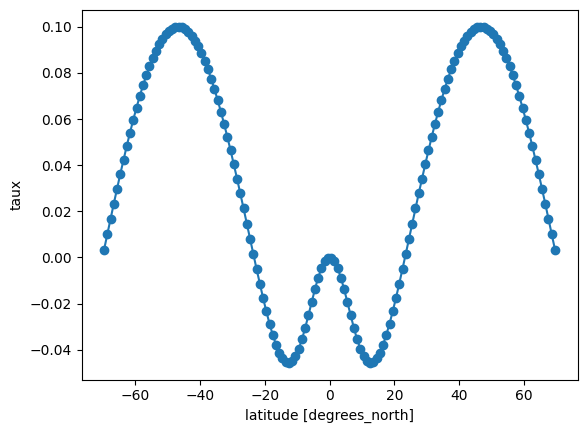

In [68]:
wind_sample.taux.mean('xq').plot(marker='o')

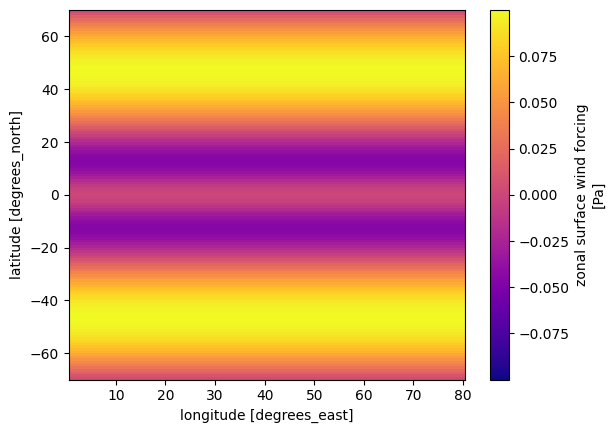

In [69]:
fig,ax=plt.subplots(nrows=1,ncols=1)
wind_sample.taux.plot(cmap='plasma')

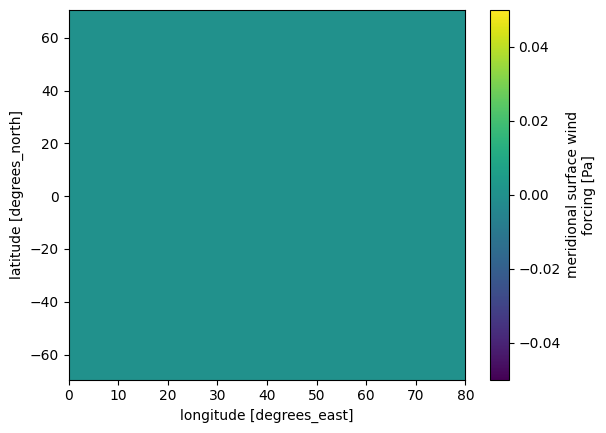

In [70]:
wind_sample.tauy.plot()

# <font color="hotpink"> Now, we will create a temperature forcing file using the same method as the wind forcing file. </font>

In [71]:
import netCDF4 as nc4
f2 = nc4.Dataset('/vortex1/jupyter-kuyeda/files_to_delete/temp_sample_nov_10.nc','w',format='NETCDF4')

In [72]:
try: ncfile.close()
except:pass
print(f2)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 


## <font color="hotpink"> create dimensions </font>

In [73]:
np.delete(for_ridge.yg,obj=0,axis=0)

array([-69., -68., -67., -66., -65., -64., -63., -62., -61., -60., -59.,
       -58., -57., -56., -55., -54., -53., -52., -51., -50., -49., -48.,
       -47., -46., -45., -44., -43., -42., -41., -40., -39., -38., -37.,
       -36., -35., -34., -33., -32., -31., -30., -29., -28., -27., -26.,
       -25., -24., -23., -22., -21., -20., -19., -18., -17., -16., -15.,
       -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,
        -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,
         8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,
        19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,
        30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,
        41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,
        52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,
        63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.])

In [74]:
xh = for_ridge.xc
yh = for_ridge.yc
xq = np.delete(for_ridge.xg,obj=0,axis=0)
yq = np.delete(for_ridge.yg,obj=0,axis=0)

In [75]:
xh_dim = f2.createDimension('xh',len(xh))
yh_dim = f2.createDimension('yh',len(yh))
xq_dim = f2.createDimension('xq',len(xq))
yq_dim = f2.createDimension('yq',len(yq))
for dim in f2.dimensions.items():
    print(dim)

('xh', <class 'netCDF4._netCDF4.Dimension'>: name = 'xh', size = 80)
('yh', <class 'netCDF4._netCDF4.Dimension'>: name = 'yh', size = 140)
('xq', <class 'netCDF4._netCDF4.Dimension'>: name = 'xq', size = 80)
('yq', <class 'netCDF4._netCDF4.Dimension'>: name = 'yq', size = 140)


## <font color="hotpink"> create attributes </font>

In [76]:
f2.title='surface temp forcing test'
print(f2.title)

surface temp forcing test


In [77]:
f2.subtitle='deg_celsius'
print(f2.subtitle)
print(f2)

deg_celsius
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: surface temp forcing test
    subtitle: deg_celsius
    dimensions(sizes): xh(80), yh(140), xq(80), yq(140)
    variables(dimensions): 
    groups: 


## <font color="hotpink"> create variables </font>

In [78]:
# coordinate variables
xh = f2.createVariable('xh',np.float32,('xh'))
xh.units = 'degrees_east'
xh.long_name = 'longitude'

In [79]:
yh = f2.createVariable('yh',np.float32,('yh'))
yh.units = 'degrees_north'
yh.long_name = 'latitude'

In [80]:
xq = f2.createVariable('xq',np.float32,('xq'))
xq.units = 'degrees_east'
xq.long_name = 'longitude'

In [81]:
yq = f2.createVariable('yq',np.float32,('yq'))
yq.units = 'degrees_north'
yq.long_name = 'latitude'

In [82]:
surf_temp = f2.createVariable('surf_temp',np.float32,('yh','xh'))
surf_temp.long_name = 'surface temperature forcing'
surf_temp.units = 'deg_Celsius'
print(surf_temp)

<class 'netCDF4._netCDF4.Variable'>
float32 surf_temp(yh, xh)
    long_name: surface temperature forcing
    units: deg_Celsius
unlimited dimensions: 
current shape = (140, 80)
filling on, default _FillValue of 9.969209968386869e+36 used


## <font color="hotpink"> assign variables </font>

In [83]:
xh[:]= for_ridge.xc
print(xh[:])
print(xh.units)

[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
 14.5 15.5 16.5 17.5 18.5 19.5 20.5 21.5 22.5 23.5 24.5 25.5 26.5 27.5
 28.5 29.5 30.5 31.5 32.5 33.5 34.5 35.5 36.5 37.5 38.5 39.5 40.5 41.5
 42.5 43.5 44.5 45.5 46.5 47.5 48.5 49.5 50.5 51.5 52.5 53.5 54.5 55.5
 56.5 57.5 58.5 59.5 60.5 61.5 62.5 63.5 64.5 65.5 66.5 67.5 68.5 69.5
 70.5 71.5 72.5 73.5 74.5 75.5 76.5 77.5 78.5 79.5]
degrees_east


In [84]:
yh[:]= for_ridge.yc
print(yh[:])
print(yh.units)

[-69.5 -68.5 -67.5 -66.5 -65.5 -64.5 -63.5 -62.5 -61.5 -60.5 -59.5 -58.5
 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 -51.5 -50.5 -49.5 -48.5 -47.5 -46.5
 -45.5 -44.5 -43.5 -42.5 -41.5 -40.5 -39.5 -38.5 -37.5 -36.5 -35.5 -34.5
 -33.5 -32.5 -31.5 -30.5 -29.5 -28.5 -27.5 -26.5 -25.5 -24.5 -23.5 -22.5
 -21.5 -20.5 -19.5 -18.5 -17.5 -16.5 -15.5 -14.5 -13.5 -12.5 -11.5 -10.5
  -9.5  -8.5  -7.5  -6.5  -5.5  -4.5  -3.5  -2.5  -1.5  -0.5   0.5   1.5
   2.5   3.5   4.5   5.5   6.5   7.5   8.5   9.5  10.5  11.5  12.5  13.5
  14.5  15.5  16.5  17.5  18.5  19.5  20.5  21.5  22.5  23.5  24.5  25.5
  26.5  27.5  28.5  29.5  30.5  31.5  32.5  33.5  34.5  35.5  36.5  37.5
  38.5  39.5  40.5  41.5  42.5  43.5  44.5  45.5  46.5  47.5  48.5  49.5
  50.5  51.5  52.5  53.5  54.5  55.5  56.5  57.5  58.5  59.5  60.5  61.5
  62.5  63.5  64.5  65.5  66.5  67.5  68.5  69.5]
degrees_north


In [85]:
xq[:]= np.delete(for_ridge.xg,obj=0,axis=0)
print([xq[:]])
print(xq.shape)

[masked_array(data=[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
                   12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22.,
                   23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33.,
                   34., 35., 36., 37., 38., 39., 40., 41., 42., 43., 44.,
                   45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
                   56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66.,
                   67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
                   78., 79., 80.],
             mask=False,
       fill_value=1e+20,
            dtype=float32)]
(80,)


In [86]:
yq[:]= np.delete(for_ridge.yg,obj=0,axis=0)
print(yq[:])
print(yq.units)
print(yq.shape)

[-69. -68. -67. -66. -65. -64. -63. -62. -61. -60. -59. -58. -57. -56.
 -55. -54. -53. -52. -51. -50. -49. -48. -47. -46. -45. -44. -43. -42.
 -41. -40. -39. -38. -37. -36. -35. -34. -33. -32. -31. -30. -29. -28.
 -27. -26. -25. -24. -23. -22. -21. -20. -19. -18. -17. -16. -15. -14.
 -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.
   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.]
degrees_north
(140,)


## <font color="hotpink"> create an array of valeus for surf_temp. </font>

$$
T = T_{eq}\left[cos\left(\frac{\pi \theta}{140}\right)^2 + 0.1e^{-\left(\frac{\theta}{2\Theta} -1\right)^2} \right]
$$

where $T_{eq} = 25^{\circ}C$ and $\Theta = 60^{\circ}$

In [87]:
yh

<class 'netCDF4._netCDF4.Variable'>
float32 yh(yh)
    units: degrees_north
    long_name: latitude
unlimited dimensions: 
current shape = (140,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [88]:
# calculate the surf_temp (yh,xh) (140,80) for every value

yh = for_ridge.yc
Teq = 25   
theta = 60

#numpy cosine is in radians

term_1 = np.cos(yh/140)
surf_temp_np = -np.cos(yh)#-70)
#surf_temp_np.shape

In [89]:
print('xval', yh[20])
print('yval',term_1[20])


xval -49.5
yval 0.938142089533106


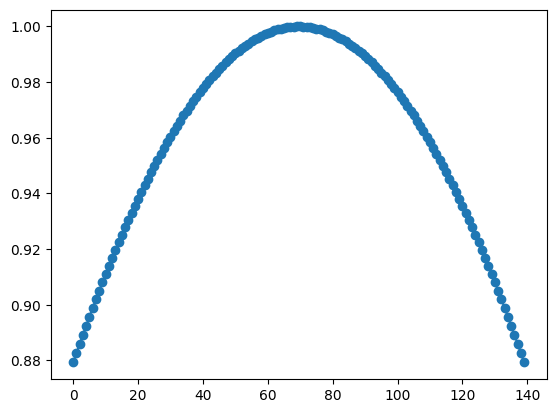

In [90]:
plt.plot(term_1,marker='o')
#plt.plot(yh,marker='x')

In [91]:
surf_temp_np.max()

0.9983462274487422

In [92]:
# calculate the taux (yh,xq) (140,81) for every value
tau_max = 0.1 # max wind
sigma = 10    # 10 deg
yh = for_ridge.yc

comp_np = tau_max*(-np.cos(3*np.pi*yh/140) + np.exp((-yh**2)/sigma**2))
#comp_np = np.cos(yh)
comp_np.shape

(140,)

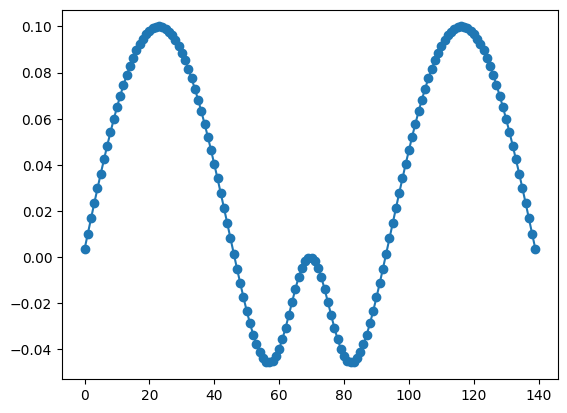

In [93]:
plt.plot(comp_np,marker='o')

In [94]:
# manually create a surf_temp (yh,xh) (140,81) size array for surf_temp(yh,xh)

# assign every cell in the array to a surf_temp value 
    # create a (140,80) numpy array
ones = np.ones((140,80))
ones.shape

    # assign the windyh.shape = (140,) values to every column in the new array
surf_temp_np=ones * surf_temp_np[:,np.newaxis]

    # MOM6 counts cells right to left, so we have xq values that extend beyond the domain. 
    # We need to remove the xq value on the opposite side of the cell, so we remove the first column of taux_np
#taux_np = np.delete(taux_np, obj=0, axis=1)
surf_temp_np.shape
#taux_np[:,1]

(140, 80)

In [95]:
surf_temp[:] = surf_temp_np
print(surf_temp[:])
print(surf_temp.units)
print(surf_temp.shape)

[[-0.9268128  -0.9268128  -0.9268128  ... -0.9268128  -0.9268128
  -0.9268128 ]
 [-0.8167513  -0.8167513  -0.8167513  ... -0.8167513  -0.8167513
  -0.8167513 ]
 [ 0.04422762  0.04422762  0.04422762 ...  0.04422762  0.04422762
   0.04422762]
 ...
 [ 0.04422762  0.04422762  0.04422762 ...  0.04422762  0.04422762
   0.04422762]
 [-0.8167513  -0.8167513  -0.8167513  ... -0.8167513  -0.8167513
  -0.8167513 ]
 [-0.9268128  -0.9268128  -0.9268128  ... -0.9268128  -0.9268128
  -0.9268128 ]]
deg_Celsius
(140, 80)


## <font color="hotpink"> Close out file </font>

In [96]:
print(f2)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: surface temp forcing test
    subtitle: deg_celsius
    dimensions(sizes): xh(80), yh(140), xq(80), yq(140)
    variables(dimensions): float32 xh(xh), float32 yh(yh), float32 xq(xq), float32 yq(yq), float32 surf_temp(yh, xh)
    groups: 


In [97]:
f1.close(); print('dataset is closed')

dataset is closed


## <font color="hotpink"> Check file </font>

In [99]:
temp_sample=xr.open_dataset('/vortex1/jupyter-kuyeda/t_m_p_wind/6-21_build_INPUT/6-21_INPUT_files/11-27_NaN_SST.nc')
temp_sample

<xarray.Dataset>
Dimensions:  (yh: 140, xh: 80, xq: 80, yq: 140)
Coordinates:
  * xh       (xh) float32 0.5 1.5 2.5 3.5 4.5 5.5 ... 75.5 76.5 77.5 78.5 79.5
  * yh       (yh) float32 -69.5 -68.5 -67.5 -66.5 -65.5 ... 66.5 67.5 68.5 69.5
  * xq       (xq) float32 1.0 2.0 3.0 4.0 5.0 6.0 ... 76.0 77.0 78.0 79.0 80.0
  * yq       (yq) float32 -69.0 -68.0 -67.0 -66.0 -65.0 ... 67.0 68.0 69.0 70.0
Data variables:
    SST      (yh, xh) float32 ...
Attributes:
    title:     surface temp forcing test
    subtitle:  deg_celsius

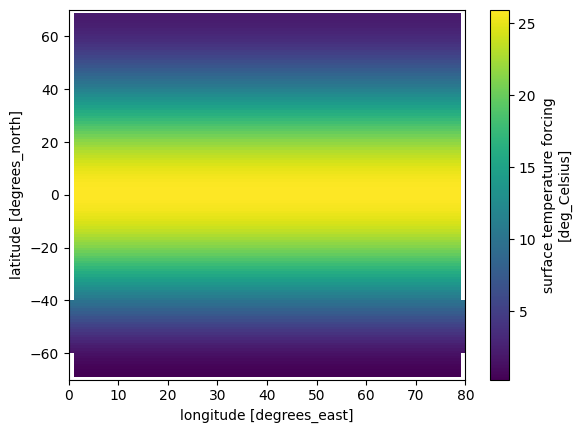

In [101]:
temp_sample.SST.plot()